In [36]:
import csv
import jieba
import pickle
import sentencepiece as spm
import pandas as pd

In [ ]:
#jieba 分词
comments = []
with open("DMSC.csv", 'r') as f:
    reader = csv.DictReader(f)
    for row in reader:                
        star = int(row['Star'])
        if star in [1, 2, 4, 5]:
            words = jieba.lcut(row['Comment'])
            comments.append((words, 1 if star<=2 else 0)) # 1=negative 0=positive
print(len(comments))

1650497


<function matplotlib.pyplot.show(close=None, block=None)>

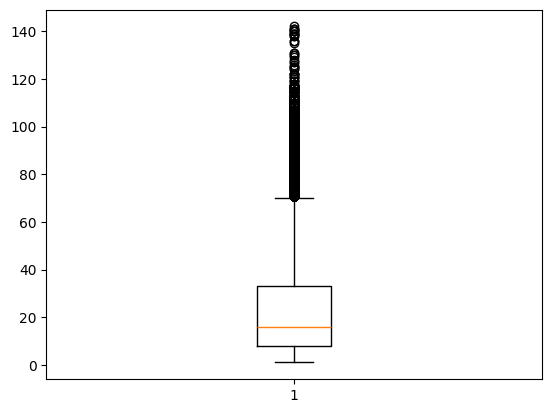

In [36]:
import matplotlib.pyplot as plt

comments_len = [len(c) for c,_ in comments]
plt.boxplot(comments_len)
plt.show

In [37]:
c_comments = [c for c in comments if len(c[0]) in range(10, 130)]
print(len(c_comments))

1130977


In [ ]:
with open('jieba_comments.pkl', 'wb') as f:
    pickle.dump(c_comments, f)

In [ ]:
# sentencePiece
df = pd.read_csv("DMSC.csv")
df["Star"] = df["Star"].astype(int)
df = df[df["Star"].isin([1,2,4,5])]
df = df[["Comment"]].dropna()
df['Comment'].astype(str).to_csv("comments.txt", index=False, header=False)

In [40]:
spm.SentencePieceTrainer.train(
    input='comments.txt',
    model_prefix='spm',
    vocab_size=10000,
    character_coverage=0.9995,
)

In [37]:
sp = spm.SentencePieceProcessor()
sp.load("spm.model")
comments_spm = []
with open("DMSC.csv", 'r') as f:
    reader = csv.DictReader(f)
    for row in reader:
        star = int(row['Star'])
        if star in [1, 2, 4, 5]:
            words = sp.encode(row["Comment"], out_type=int)
            comments_spm.append((words, 1 if star<=2 else 0)) # 1=negative 0=positive
# 保存为 pickle
with open("spm_vocab.pkl", "wb") as f:
    pickle.dump(comments_spm, f)


# jieba

In [29]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

In [3]:
class Comments_Classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        # output: (batch_size, seq_len, hidden_size)
        output, _ = self.rnn(embedded)
        output = self.fc(output[:, -1, :])  # 取最后一个时间步的输出
        return output

In [4]:
# build vocab (jieba)
def build_from_doc(doc):
    vocab_set = set()
    for line in doc:
        vocab_set.update(line[0])

    vocab_list =  ['PAD','UNK'] + list(vocab_set)  # PAD: padding, UNK: unknown
    vocab = {word: idx for idx, word in enumerate(vocab_list)}
    return vocab

In [5]:
with open('jieba_comments.pkl','rb') as f:
    comments_data = pickle.load(f)
    f.close()
# label_set = set([label for _, label in comments_data])
# print("标签值集合：", label_set)    
vocab = build_from_doc(comments_data)


In [25]:
# 自定义数据转换方法(callback function)回调函数
# 该函数会在每个batch数据加载时被调用
def convert_data_jieba(batch_data):
    comments, votes = [],[]
    # 分别提取评论和标签
    for comment, vote in batch_data:
        token_ids = [vocab.get(word, vocab['UNK']) for word in comment]
        # for idx in token_ids:
        #     assert 0 <= idx < len(vocab), f"ID 越界: {idx} >= vocab_size={len(vocab)}"
        comments.append(torch.tensor(token_ids))
        # comments.append(torch.tensor([vocab.get(word, vocab['UNK']) for word in comment]))
        votes.append(vote)
    # 将评论和标签转换为tensor
    # print("标签 unique:", set(votes))
    comment = pad_sequence(comments, batch_first=True, padding_value=vocab['PAD'])  # 填充为相同长度
    labels = torch.tensor(votes).long()
    # 返回评论和标签
    return comment, labels

In [31]:
def train_process(model, dataloader, tag = 'jieba'):
    writer = SummaryWriter(f'runs/{tag}')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # device = torch.device('cpu')
    model.to(device)
    # 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # 训练模型
    num_epochs = 3
    for epoch in range(num_epochs):
        loop = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{num_epochs}")
        for i, (cmt, lbl) in loop:
            cmt = cmt.to(device)
            lbl = lbl.to(device)

            # 前向传播
            outputs = model(cmt)
            loss = criterion(outputs, lbl)

            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loop.set_postfix(loss=loss.item())    
            if (i+1) % 100 == 0:
                writer.add_scalar('Loss/train', loss.item(), epoch * len(dataloader) + i)
                # print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}')



In [32]:
model_jieba = Comments_Classifier(vocab_size=len(vocab)+1, embedding_dim=100,
                                   hidden_size=64, num_classes=2)
dataloader_jieba = DataLoader(comments_data, batch_size=256, shuffle=True, collate_fn=convert_data_jieba)

In [33]:
train_process(model=model_jieba, dataloader=dataloader_jieba)
# 保存模型
torch.save(model_jieba.state_dict(), 'comments_jieba.pth')
# 模型词典
torch.save(vocab, 'comments_jieba_vocab.pth')

Epoch 3/3: 100%|██████████| 4418/4418 [01:44<00:00, 42.40it/s, loss=0.195] 


# sq

In [38]:
with open('spm_vocab.pkl','rb') as f:
    spm_comments = pickle.load(f)
    print(spm_comments[1])
    print(sp.id_to_piece(spm_comments[1][0]))
    f.close()
    

([3499, 2613, 73, 379, 459, 6, 641, 317, 317, 6033, 44, 3, 784, 1671, 989, 4922, 4902, 1028, 214, 641, 747, 723, 3, 784, 1671, 174, 1029, 347, 1721, 214, 641, 1606, 2580, 79, 274, 3, 784, 1671, 838, 1419, 2660, 214, 641, 387, 25, 5002, 3, 784, 1671, 5002, 1414, 853, 6, 327, 8, 36, 31, 693, 5, 5028, 292, 121, 3, 39, 693, 1697, 914, 1397, 44, 101, 1629, 6, 819, 3830, 2360, 874, 12, 1401, 1627, 130, 3, 3239, 7, 3, 154, 3587, 216, 6], 1)
['▁2015', '年度', '最', '失望', '作品', '。', '以为', '面', '面', '俱', '到', ',', '实', '则', '画', '蛇', '添', '足', ';', '以为', '主题', '深刻', ',', '实', '则', '老', '调', '重', '弹', ';', '以为', '推', '陈', '出', '新', ',', '实', '则', '俗', '不可', '耐', ';', '以为', '场面', '很', 'high', ',', '实', '则', 'high', '劲', '不足', '。', '气', '!', '上', '一', '集', '的', '趣味', '全', '无', ',', '这', '集', '的笑点', '明显', '刻意', '到', '心', '虚', '。', '全片', '没有任何', '片段', '给我', '有', '紧张', '激动', '的时候', ',', '太弱', '了', ',', '跟', '奥创', '一样', '。']


In [41]:
vocab_size = sp.get_piece_size()

In [46]:
def convert_data_spm(batch_data):
    comments, votes = [], []
    for ids, label in batch_data:
        comments.append(torch.tensor(ids).long())  # 已经是 int id 列表
        votes.append(label)
    comment = pad_sequence(comments, batch_first=True, padding_value=0)# 用0 padding
    labels = torch.tensor(votes).long()
    return comment, labels

In [47]:
model_spm = Comments_Classifier(vocab_size=vocab_size, embedding_dim=150,
                                   hidden_size=128, num_classes=2)
dataloader_spm = DataLoader(spm_comments, batch_size=256, shuffle=True, collate_fn=convert_data_spm)

In [48]:
train_process(model=model_spm, dataloader=dataloader_spm, tag='spm/complex')

Epoch 3/3: 100%|██████████| 6448/6448 [03:21<00:00, 32.05it/s, loss=0.186]
